# Random CNNs

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import cv2, os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random
from pathlib import Path
#torch.cuda.set_device(1)

## Looking at the CIFAR-10 data

In [2]:
import matplotlib.pyplot as plt 

In [132]:
PATH = Path("/data2/datasets/part1/cifar10/")

In [4]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [5]:
IMG_PATH = PATH/'train/airplane'
path_f = list(IMG_PATH.iterdir())[1]
path_f

PosixPath('/data2/datasets/part1/cifar10/train/airplane/27147_airplane.png')

In [6]:
img = cv2.imread(str(path_f))

In [7]:
img.shape

(32, 32, 3)

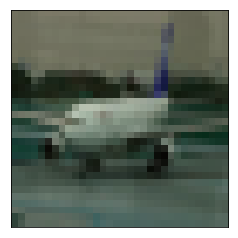

In [8]:
show_img(img)

## Dataset 

In [9]:
# from fast AI
def read_dirs(path, folder):
    labels, filenames, all_labels = [], [], []
    full_path = os.path.join(path, folder)
    for label in sorted(os.listdir(full_path)):
        if label not in ('.ipynb_checkpoints','.DS_Store'):
            all_labels.append(label)
            for fname in os.listdir(os.path.join(full_path, label)):
                filenames.append(os.path.join(folder, label, fname))
                labels.append(label)
    return filenames, labels, all_labels

In [10]:
filenames, labels, all_labels = read_dirs(PATH, "test")

In [11]:
label2idx = {label:i for i,label in enumerate(all_labels)}

In [12]:
y = [label2idx[l] for l in labels]

In [133]:
class CIFARDataset(Dataset):
    def __init__(self, path, folder, transform=False):
        self.path = path
        filenames, labels, all_labels = read_dirs(path, folder)
        label2idx = {label:i for i,label in enumerate(all_labels)}
        self.y = [label2idx[l] for l in labels]
        self.filenames = filenames
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        path_f = self.path/self.filenames[idx]
        img = cv2.imread(str(path_f)).astype(np.float32)/255
        if self.transform:
            img = random_flip(img)
            img = padding(img)
            img = random_crop(img, 32, 32)
        return np.rollaxis(img, 2), self.y[idx]

In [134]:
train_ds = CIFARDataset(PATH, "train", transform=True)
test_ds = CIFARDataset(PATH, "test")

In [38]:
#train[0]

In [39]:
bs = 10
bs = 128
train_loader = DataLoader(train, batch_size=bs, shuffle=True)
test_loader = DataLoader(test, batch_size=bs, shuffle=False)

## Data Augmentation

In [16]:
# version from fast.ai
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

In [17]:
def padding(x, pad=4):
    return cv2.copyMakeBorder(x, pad, pad, pad, pad, cv2.BORDER_REFLECT)

In [18]:
def random_flip(x, p=0.5):
    return np.fliplr(x).copy() if random.random() < p else x

In [19]:
path_f="/data2/datasets/part1/cifar10/train/airplane/27147_airplane.png"
img = cv2.imread(path_f).astype(np.float32)/255

In [20]:
img.shape

(32, 32, 3)

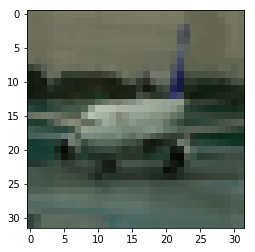

In [21]:
from matplotlib import pyplot as plt
plt.imshow(img)

In [22]:
img2 = random_flip(img)
img2 = padding(img2)
img2 = random_crop(img2, 32, 32)
img2.shape

(32, 32, 3)

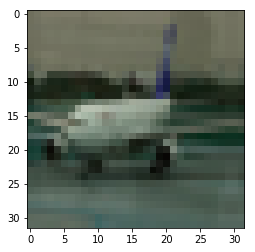

In [23]:
plt.imshow(img2)

## Model

In [52]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1))

In [61]:
class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [62]:
# from fast.ai
class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

In [108]:
class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, num_classes, nf=32, random=False, K=4):
        super().__init__()
        self.random = random
        top_layers = [conv_layer(3, nf, ks=3, stride=1)]
        bottom_layers = []
        for i,nb in enumerate(num_blocks[:K]):
            top_layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
        for i,nb in enumerate(num_blocks[K:]):
            bottom_layers += self.make_group_layer(nf, nb, stride=2)
            nf *= 2
        bottom_layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        self.top_model = nn.Sequential(*top_layers)
        self.bottom_model = nn.Sequential(*bottom_layers)
    
    def forward(self, x):
        if self.random:
            with torch.no_grad():
                x = self.top_model(x)
        else:
            x = self.top_model(x)
        return self.bottom_model(x)

In [97]:
model1 = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=32).cuda()

In [98]:
model2 = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=32, random=True).cuda()

## Testing model

In [89]:
x, y = next(iter(train_loader))
x = x.cuda()
model(x).shape

torch.Size([128, 10])

## Train

In [99]:
def train(train_loader, model, optimizer):
    model.train()
    sum_loss = 0.0
    total = 0
    for i, (x, labels) in enumerate(train_loader):  
        batch = x.shape[0]
        x = x.cuda() 
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(x).float()
        loss = F.cross_entropy(outputs, labels) 
        loss.backward()
        optimizer.step()
        
        total += batch
        sum_loss += batch * loss.item()
    train_loss = sum_loss/total
    return train_loss

def model_eval(model, test_loader):
    model.eval()
    sum_loss = 0.0
    total_correct = 0.0
    total = 0
    for x, labels in test_loader:
        x = x.cuda()
        labels = labels.cuda()
        outputs = model(x)
        loss = F.cross_entropy(outputs, labels) 
        sum_loss += labels.size(0)*loss.item()
        corr = correct(outputs, labels)
        total_correct += corr
        total += labels.size(0)
    return sum_loss/total, total_correct/total

def train_model_epochs_class(train_loader, test_loader, num_epochs, model, optimizer):
    for epoch in range(num_epochs):
        train_loss = train(train_loader, model, optimizer)
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_loss, acc = model_eval(model, test_loader)
        print('Epoch [%d/%d], Valid loss: %.4f, Accuracy: %.4f' %(epoch+1, num_epochs, val_loss, acc))

In [187]:
def correct(preds, targs):
    preds = torch.max(preds, dim=1)[1]
    return (preds==targs).float().sum()

In [101]:
lr = 0.05
optimizer1 = optim.Adam(model1.parameters(), lr=lr)
optimizer2 = optim.Adam(model2.bottom_model.parameters(), lr=lr)

## Triangular learning rates

In [140]:
PATH=Path("/data2/yinterian/rand_exp")

In [158]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    return optim

In [160]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda().long()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1     
    load_model(model, str(p))
    return lrs, losses

In [189]:
model1 = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=32).cuda()

In [177]:
bs = 128
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(test_ds, batch_size=bs, shuffle=False)

In [168]:
lrs, losses = LR_range_finder(model1, train_dl, lr_low=1e-7, lr_high=0.1)

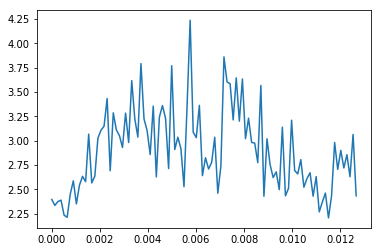

In [170]:
plt.plot(lrs[:100], losses[:100])
plt.show()

In [172]:
def get_triangular_lr2(lr_low, lr_high, iterations):
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [193]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5, lr_high=0.01, epochs=4):
    idx = 0
    iterations = epochs * len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, iterations)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().long()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss", sum_loss/total)
        val_metrics(model, valid_dl)
    return sum_loss/total

In [186]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    total_correct = 0 
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().long()
        out = model(x)
        total_correct += correct(out, y)
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss and accuracy", sum_loss/total, total_correct/total)

In [200]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=1, lr_low=1e-5, lr_high=0.01, epochs=4):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high, epochs)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [203]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    return optim

In [204]:
model1 = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=32).cuda()

In [205]:
training_loop(model1, train_dl, valid_dl, epochs=20)

train loss 1.778286909713745
val loss and accuracy 13.077882623291016 tensor(0.2942, device='cuda:0')
train loss 1.3490417552947997
val loss and accuracy 351.91596081237793 tensor(0.1070, device='cuda:0')
train loss 1.0460927820587158
val loss and accuracy 15.390155635070801 tensor(0.4822, device='cuda:0')
train loss 0.909393859500885
val loss and accuracy 17.467391454505922 tensor(0.3609, device='cuda:0')
train loss 0.8206612530708313
val loss and accuracy 1.7126362140655518 tensor(0.6232, device='cuda:0')
train loss 0.7860180308914184
val loss and accuracy 13.004736430931091 tensor(0.4828, device='cuda:0')
train loss 0.7489197580337524
val loss and accuracy 4.782161122894287 tensor(0.5174, device='cuda:0')
train loss 0.6853230744552612
val loss and accuracy 2.7801083164453506 tensor(0.7113, device='cuda:0')
train loss 0.5762360938262939
val loss and accuracy 0.8356349981307983 tensor(0.7482, device='cuda:0')
train loss 0.4904272579193115
val loss and accuracy 1.0419749334573745 tenso

### training model2

In [206]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    optim = torch.optim.Adam(model.bottom_model.parameters(), lr=lr, weight_decay=wd)
    return optim

In [207]:
model2 = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=32, random=True).cuda()

In [208]:
training_loop(model2, train_dl, valid_dl, epochs=20)

train loss 2.026103617095947
val loss and accuracy 5.537534884262085 tensor(0.1340, device='cuda:0')
train loss 1.9590899055480957
val loss and accuracy 2.2121348545074464 tensor(0.2841, device='cuda:0')
train loss 1.8120381982040406
val loss and accuracy 2.4133684783935547 tensor(0.2316, device='cuda:0')
train loss 1.7702688903808594
val loss and accuracy 2.0754333267211913 tensor(0.3290, device='cuda:0')
train loss 1.7454834159088135
val loss and accuracy 1.8517014503479003 tensor(0.3524, device='cuda:0')
train loss 1.7366875255584717
val loss and accuracy 2.070096922302246 tensor(0.2945, device='cuda:0')
train loss 1.7399598598861694
val loss and accuracy 2.3180206420898437 tensor(0.3112, device='cuda:0')
train loss 1.720271863746643
val loss and accuracy 1.8631343963623046 tensor(0.3565, device='cuda:0')
train loss 1.680776440925598
val loss and accuracy 1.6414521934509276 tensor(0.4117, device='cuda:0')
train loss 1.6512116528701781
val loss and accuracy 1.6802309898376464 tensor(